In [2]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

## Constants

In [3]:
# Taken from https://deepgraphlearning.github.io/project/wikidata5m
WIKIDATA5M_TRANSDUCTIVE_NUM_ENTITIES = 4_594_485

# Set Seaborn theme
SEABORN_THEME = 'darkgrid'
sns.set_theme(style=SEABORN_THEME)

## Load Wikidata5M

In [4]:
# Load Wikidata5M to check how often selected predicates
# occur in the training set
wikidata5m_train = pd.read_csv('dataset/wikidata5m/wikidata5m_transductive_train.txt', sep='\t', names=['S', 'P', 'O'])

## Acquiring relevant metrics from dim32 embeddings

In [5]:
dim32_predicate_metrics = pd.read_csv('metrics/predicate_metrics.csv')

# Only consider realistic values, evaluated on both ends
dim32_predicate_metrics = dim32_predicate_metrics.query('Type == "realistic" and Side == "both"')

In [6]:
# Filter for selected metrics to compare on
selected_metrics = ['arithmetic_mean_rank', 'hits_at_5', 'hits_at_10']

dim32_predicate_metrics = dim32_predicate_metrics[dim32_predicate_metrics['Metric'].isin(selected_metrics)]
dim32_predicate_metrics

,Side,Type,Metric,Value,relation_id,relation_label,model
140,both,realistic,arithmetic_mean_rank,828467.750,1,P1001,complex
194,both,realistic,hits_at_5,0.000,1,P1001,complex
203,both,realistic,hits_at_10,0.000,1,P1001,complex
365,both,realistic,arithmetic_mean_rank,1950983.625,3,P101,complex
419,both,realistic,hits_at_5,0.000,3,P101,complex
...,...,...,...,...,...,...,...
188744,both,realistic,hits_at_5,0.500,813,P945,transe
188753,both,realistic,hits_at_10,0.500,813,P945,transe
188915,both,realistic,arithmetic_mean_rank,16547.375,815,P97,transe
188969,both,realistic,hits_at_5,0.250,815,P97,transe


## Acquiring relevant metrics from dim512 embeddings

In [7]:
dim512_distmult_metrics = pd.read_csv('embeddings/dim_512/distmult/predicate_metrics.csv')
dim512_simple_metrics = pd.read_csv('embeddings/dim_512/simple/predicate_metrics.csv')
dim512_transe_metrics = pd.read_csv('embeddings/dim_512/transe/predicate_metrics.csv')

dim512_predicate_metrics = pd.concat([dim512_distmult_metrics, dim512_simple_metrics, dim512_transe_metrics])
dim512_predicate_metrics = dim512_predicate_metrics.query('Type == "realistic" and Side == "both"')

In [8]:
# Filter for selected metrics
dim512_predicate_metrics = dim512_predicate_metrics[dim512_predicate_metrics['Metric'].isin(selected_metrics)]
dim512_predicate_metrics

,Side,Type,Metric,Value,relation_id,relation_label,model
86,both,realistic,arithmetic_mean_rank,381136.562500,0,P31,distmult
194,both,realistic,hits_at_5,0.373626,0,P31,distmult
203,both,realistic,hits_at_10,0.391209,0,P31,distmult
311,both,realistic,arithmetic_mean_rank,85242.468750,1,P1412,distmult
419,both,realistic,hits_at_5,0.382353,1,P1412,distmult
...,...,...,...,...,...,...,...
46994,both,realistic,hits_at_5,0.500000,469,P511,transe
47003,both,realistic,hits_at_10,0.500000,469,P511,transe
47174,both,realistic,arithmetic_mean_rank,76.000000,492,P832,transe
47219,both,realistic,hits_at_5,0.000000,492,P832,transe


## Utility Functions

In [10]:
def get_wikidata_property_labels(property_ids: list) -> dict:
    wikidata_api = 'https://www.wikidata.org/w/api.php'
    params = {
        'action': 'wbgetentities',
        'ids': '|'.join(property_ids),
        'languages': 'en',
        'props': 'labels',
        'format': 'json'
    }

    response = requests.get(wikidata_api, params).json()

    property_labels = {}
    for pid in property_ids:
        property_labels[pid] = response['entities'][pid]['labels']['en']['value']

    return property_labels


def get_metric_label(metric_name):
    if metric_name == 'arithmetic_mean_rank':
        return 'Arithmetic Mean Rank'
    elif metric_name == 'hits_at_5':
        return 'Hits at 5'
    elif metric_name == 'hits_at_10':
        return 'Hits at 10'

    return metric_name


def set_plot_legend_texts(plot_ax, legend_title, legend_labels):
    legend = plot_ax.get_legend()
    legend.set_title(legend_title)
    
    for lt, label in zip(legend.texts, legend_labels):
        lt.set_text(label)

## Metric Histograms for selected metrics

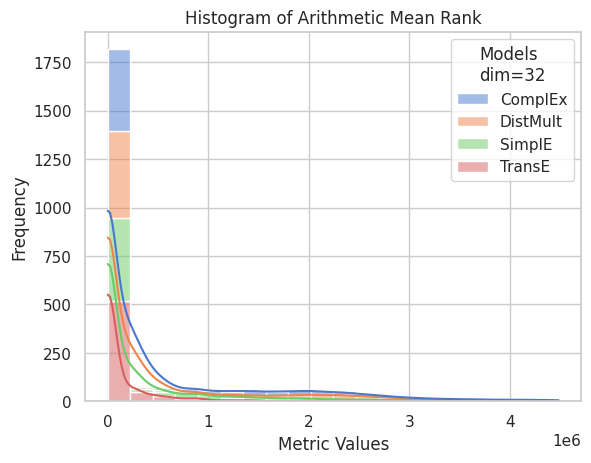

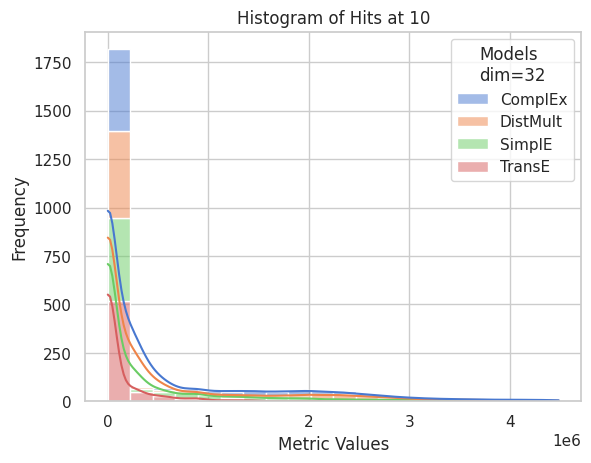

In [9]:
def plot_metric_histogram(metrics_df, metric_name, embedding_dim=32):
    sns.set_theme(style=SEABORN_THEME)

    models_list = metrics_df['model'].sort_values().unique()
    metric_label = get_metric_label(metric_name)
    model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']

    if 'complex' not in models_list:
        model_labels = ['DistMult', 'SimplE', 'TransE']

    # Create a joint plot
    sns.set(style="whitegrid")
    ax = sns.histplot(data=metrics_df, x='Value', hue='model', bins=20, kde=True, multiple="stack", palette="muted")

    # Change legend labels and title to capitalized names
    set_plot_legend_texts(ax, f'Models\ndim={embedding_dim}', model_labels)

    # Add titles and labels
    plt.title(f'Histogram of {metric_label}')
    plt.xlabel('Metric Values')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()


plot_metric_histogram(dim32_predicate_metrics, 'arithmetic_mean_rank', embedding_dim=32)
plot_metric_histogram(dim32_predicate_metrics, 'hits_at_10', embedding_dim=32)

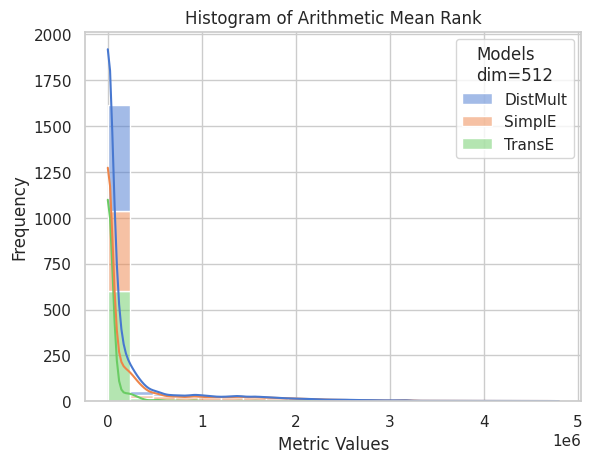

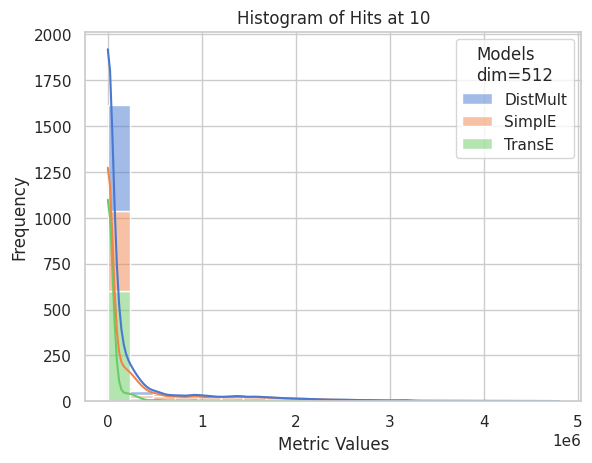

In [10]:
plot_metric_histogram(dim512_predicate_metrics, 'arithmetic_mean_rank', embedding_dim=512)
plot_metric_histogram(dim512_predicate_metrics, 'hits_at_10', embedding_dim=512)

## Metric Distributions over all predicates

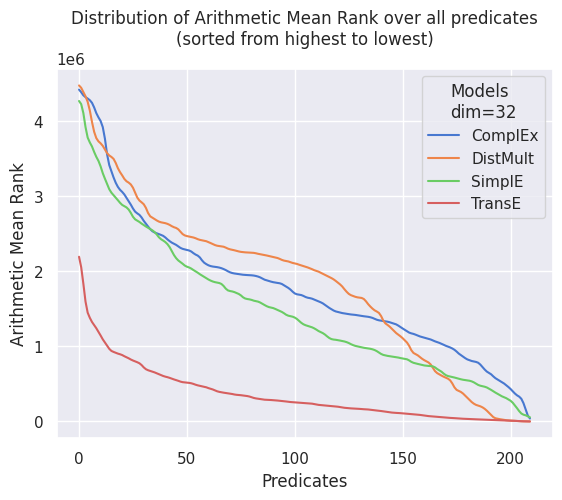

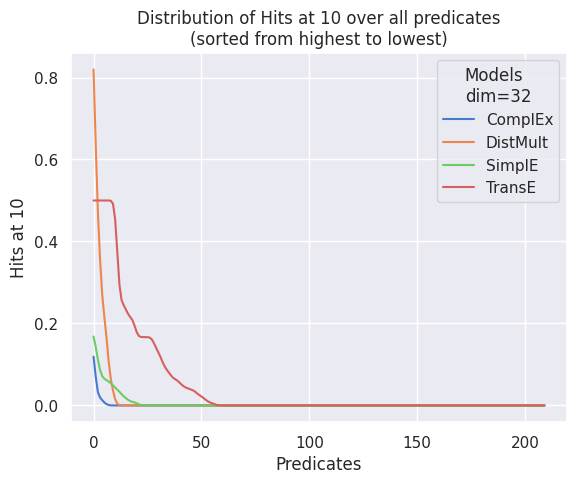

In [11]:
def compute_savgol_filter(metrics_df, window_size, polyorder):
    return metrics_df.assign(value_smooth=savgol_filter(metrics_df['Value'], window_size, polyorder))


def compute_gaussian_filter(metrics_df, sigma=1):
    return metrics_df.assign(value_smooth=gaussian_filter1d(metrics_df['Value'], sigma=sigma))


def plot_predicate_metric_distributions(predicate_metrics, metric_name, embedding_dim=32, smoothen=True):
    sns.set_theme(style=SEABORN_THEME)

    metrics_df = predicate_metrics[predicate_metrics['Metric'] == metric_name]

    metric_label = get_metric_label(metric_name)
    models_list = metrics_df['model'].sort_values().unique()
    model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']

    if 'complex' not in models_list:
        model_labels = ['DistMult', 'SimplE', 'TransE']

    smoothen_window_size = 10
    smoothen_polyorder = 2

    indexed_metrics = []
    for model in models_list:
        model_metrics = metrics_df[metrics_df['model'] == model]
        model_metrics = model_metrics.sort_values(by='Value', ascending=False, ignore_index=True).reset_index()

        if smoothen:
            model_metrics = compute_gaussian_filter(model_metrics, sigma=1)

        indexed_metrics.append(model_metrics)

    indexed_metrics_df = pd.concat(indexed_metrics)

    value_column = 'Value'
    if smoothen:
        value_column = 'value_smooth'

    ax = sns.lineplot(x='index', y=value_column, hue='model', data=indexed_metrics_df, estimator='mean',
                     palette='muted')

    # Change legend labels and title to capitalized names
    set_plot_legend_texts(ax, f'Models\ndim={embedding_dim}', model_labels)

    plt.title(f'Distribution of {metric_label} over all predicates\n(sorted from highest to lowest)')
    plt.xlabel('Predicates')
    plt.ylabel(metric_label)

    plt.show()


plot_predicate_metric_distributions(dim32_predicate_metrics, 'arithmetic_mean_rank', embedding_dim=32)
plot_predicate_metric_distributions(dim32_predicate_metrics, 'hits_at_10', embedding_dim=32)

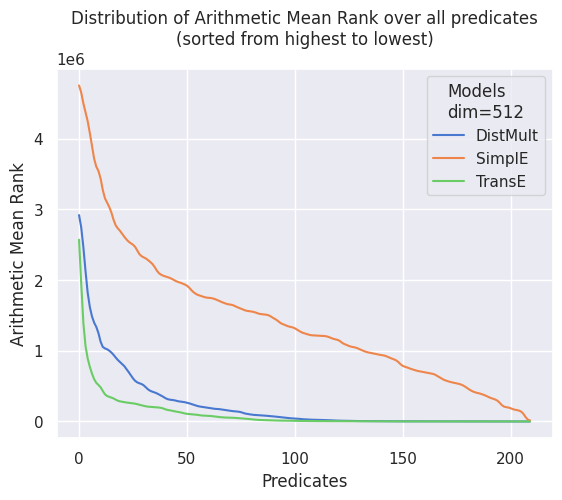

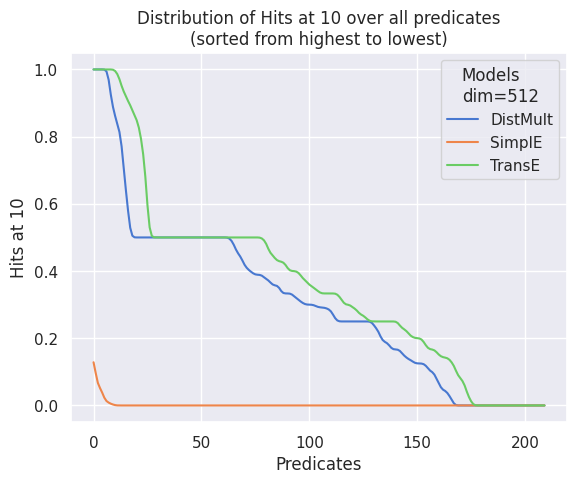

In [12]:
plot_predicate_metric_distributions(dim512_predicate_metrics, 'arithmetic_mean_rank', embedding_dim=512)
plot_predicate_metric_distributions(dim512_predicate_metrics, 'hits_at_10', embedding_dim=512)

## Selecting predicates with varying metrics per model 

In [13]:
def find_largest_metric_variances(predicate_metrics):
    predicates = predicate_metrics['relation_label'].unique()
    metric_names = predicate_metrics['Metric'].unique()
    model_names = predicate_metrics['model'].unique()

    metric_values = np.empty((len(predicates), len(metric_names), len(model_names)))

    for y, metric_name in enumerate(metric_names):
        for z, model_name in enumerate(model_names):
            metrics = predicate_metrics.query('Metric == @metric_name and model == @model_name')

            metric_values[:, y, z] = metrics['Value'].values

    metric_variances = np.var(metric_values, axis=2).mean(axis=1)

    variances_df = pd.DataFrame({
        'relation_label': predicates,
        'variance': metric_variances
    })

    return variances_df.sort_values(by='variance', ascending=False, ignore_index=True)


variances_df = find_largest_metric_variances(dim32_predicate_metrics)

# Limit to the highest 5 variances
variances_df = variances_df.head(5)

In [14]:
def filter_metrics(metrics_df, metric_name, filter_func):
    return metrics_df[metrics_df.apply(lambda x: x.Metric == metric_name and filter_func(x.Value), axis=1)]


dim32_hits10_nonzero = filter_metrics(dim32_predicate_metrics, 'hits_at_10', lambda value: value > 0)
dim32_hits10_nonzero.sort_values(by='Value', ascending=False)

,Side,Type,Metric,Value,relation_id,relation_label,model
81428,both,realistic,hits_at_10,1.000000,615,P460,distmult
174803,both,realistic,hits_at_10,0.500000,590,P4312,transe
84128,both,realistic,hits_at_10,0.500000,641,P516,distmult
152303,both,realistic,hits_at_10,0.500000,133,P1435,transe
188753,both,realistic,hits_at_10,0.500000,813,P945,transe
...,...,...,...,...,...,...,...
39578,both,realistic,hits_at_10,0.005495,695,P641,complex
182678,both,realistic,hits_at_10,0.005000,714,P69,transe
179303,both,realistic,hits_at_10,0.004926,656,P54,transe
26528,both,realistic,hits_at_10,0.003304,461,P31,complex


In [15]:
filter_metrics(dim32_predicate_metrics, 'hits_at_5', lambda value: value > 0).sort_values(by='Value', ascending=False)

,Side,Type,Metric,Value,relation_id,relation_label,model
81419,both,realistic,hits_at_5,1.000000,615,P460,distmult
188744,both,realistic,hits_at_5,0.500000,813,P945,transe
186944,both,realistic,hits_at_5,0.500000,779,P859,transe
174794,both,realistic,hits_at_5,0.500000,590,P4312,transe
152294,both,realistic,hits_at_5,0.500000,133,P1435,transe
...,...,...,...,...,...,...,...
136769,both,realistic,hits_at_5,0.004762,726,P735,simple
184019,both,realistic,hits_at_5,0.002381,726,P735,transe
148019,both,realistic,hits_at_5,0.002212,83,P131,transe
100769,both,realistic,hits_at_5,0.002212,83,P131,simple


In [16]:
def select_duplicate_values(df, column):
    groups = df.groupby(by=column).size().sort_values(ascending=False)
    return pd.concat([df[df[column] == value] for value in groups[groups > 1].index.values])


select_duplicate_values(dim32_hits10_nonzero, 'relation_label')

,Side,Type,Metric,Value,relation_id,relation_label,model
26528,both,realistic,hits_at_10,0.003304,461,P31,complex
121028,both,realistic,hits_at_10,0.044604,461,P31,simple
168278,both,realistic,hits_at_10,0.042401,461,P31,transe
2228,both,realistic,hits_at_10,0.020677,27,P106,complex
96728,both,realistic,hits_at_10,0.056391,27,P106,simple
143978,both,realistic,hits_at_10,0.054511,27,P106,transe
32378,both,realistic,hits_at_10,0.037037,574,P413,complex
126878,both,realistic,hits_at_10,0.138889,574,P413,simple
174128,both,realistic,hits_at_10,0.212963,574,P413,transe
32828,both,realistic,hits_at_10,0.021053,584,P421,complex


In [17]:
dim512_hits10_nonzero = filter_metrics(dim512_predicate_metrics, 'hits_at_10', lambda value: value > 0)
dim512_hits10_nonzero.sort_values(by='Value', ascending=False)

,Side,Type,Metric,Value,relation_id,relation_label,model
19553,both,realistic,hits_at_10,1.000000,98,P22,transe
19553,both,realistic,hits_at_10,1.000000,98,P22,distmult
35528,both,realistic,hits_at_10,1.000000,212,P451,distmult
35303,both,realistic,hits_at_10,1.000000,208,P1327,transe
34853,both,realistic,hits_at_10,1.000000,206,P1029,distmult
...,...,...,...,...,...,...,...
4478,both,realistic,hits_at_10,0.010526,20,P421,simple
13703,both,realistic,hits_at_10,0.010204,67,P171,transe
3578,both,realistic,hits_at_10,0.009470,16,P17,simple
2453,both,realistic,hits_at_10,0.003759,11,P106,simple


In [18]:
select_duplicate_values(dim512_hits10_nonzero, 'relation_label')

,Side,Type,Metric,Value,relation_id,relation_label,model
878,both,realistic,hits_at_10,0.322742,3,P27,distmult
878,both,realistic,hits_at_10,0.003344,3,P27,simple
878,both,realistic,hits_at_10,0.426421,3,P27,transe
203,both,realistic,hits_at_10,0.391209,0,P31,distmult
203,both,realistic,hits_at_10,0.156593,0,P31,simple
...,...,...,...,...,...,...,...
37778,both,realistic,hits_at_10,0.500000,234,P2175,transe
8078,both,realistic,hits_at_10,0.305556,37,P175,distmult
8078,both,realistic,hits_at_10,0.430556,37,P175,transe
5603,both,realistic,hits_at_10,0.291667,25,P176,distmult


## Metric Comparison on selected predicates

In [11]:
example_predicates = ['P31', 'P106', 'P413', 'P421', 'P641', 'P47', 'P1344', 'P364']
example_wd_labels = get_wikidata_property_labels(example_predicates)
example_wd_labels

{'P31': 'instance of',
 'P106': 'occupation',
 'P413': 'position played on team / speciality',
 'P421': 'located in time zone',
 'P641': 'sport',
 'P47': 'shares border with',
 'P1344': 'participant in',
 'P364': 'original language of film or TV show'}

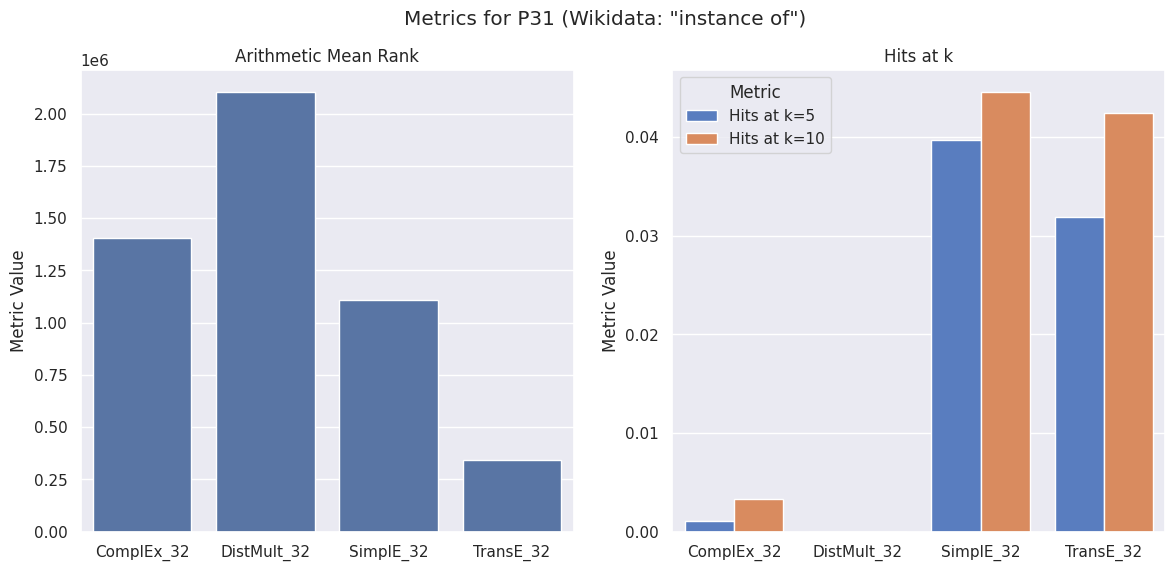

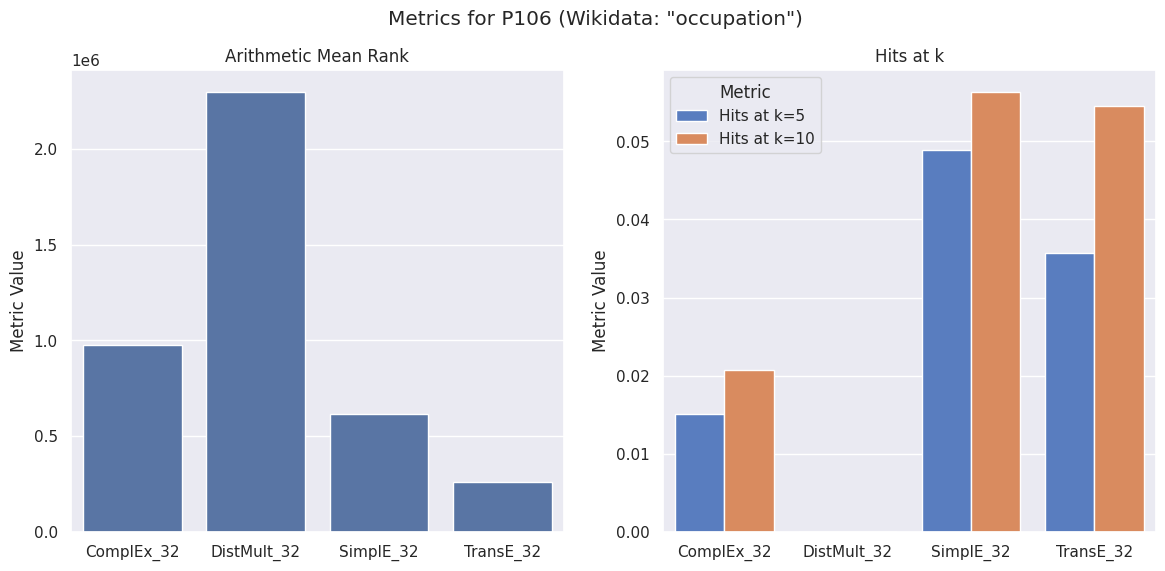

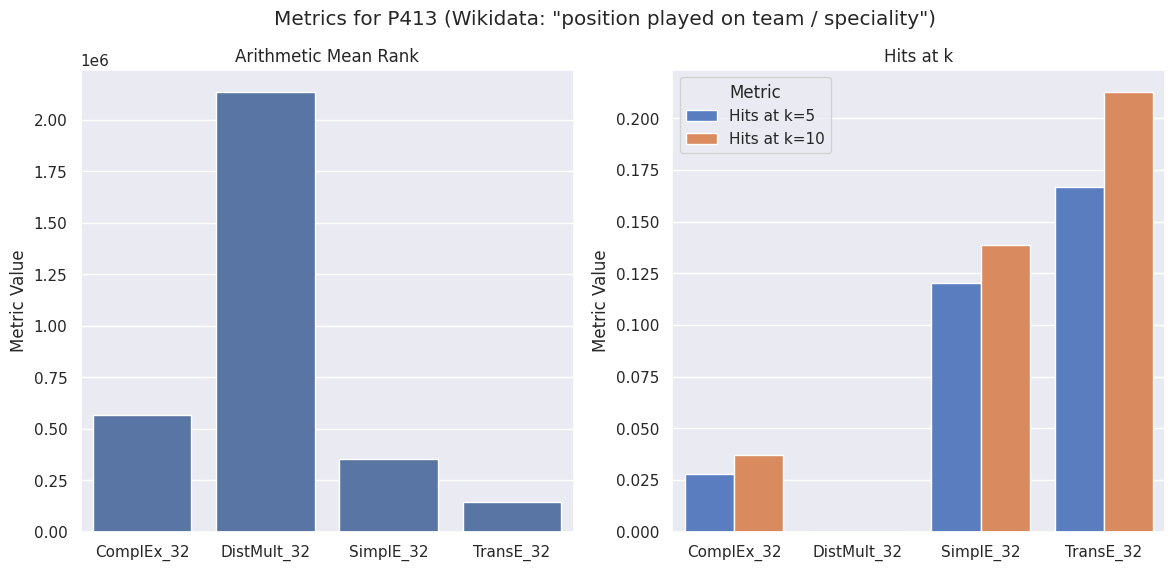

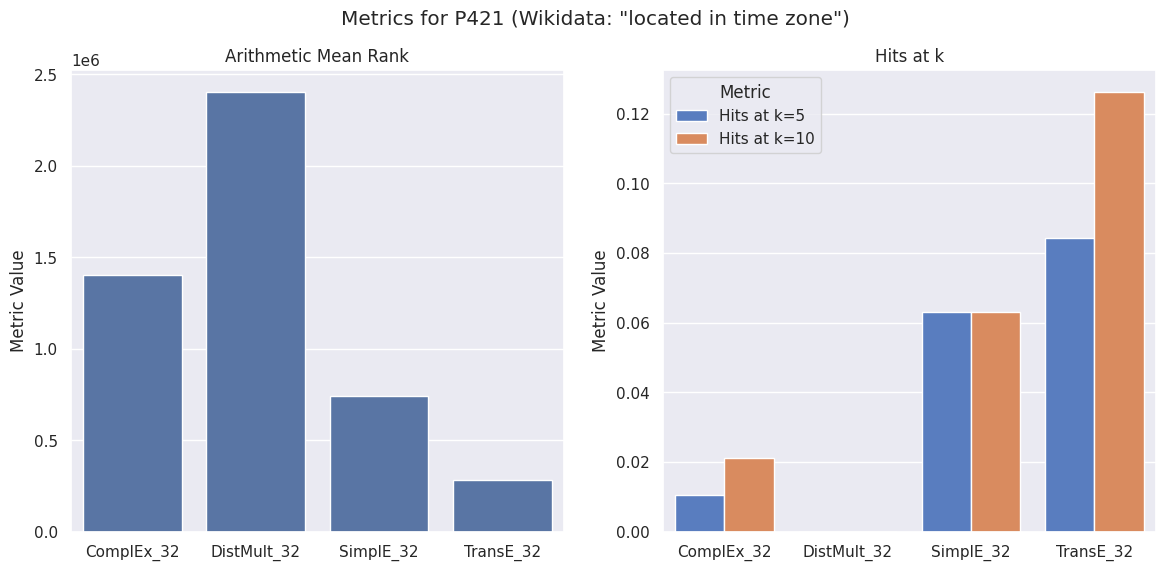

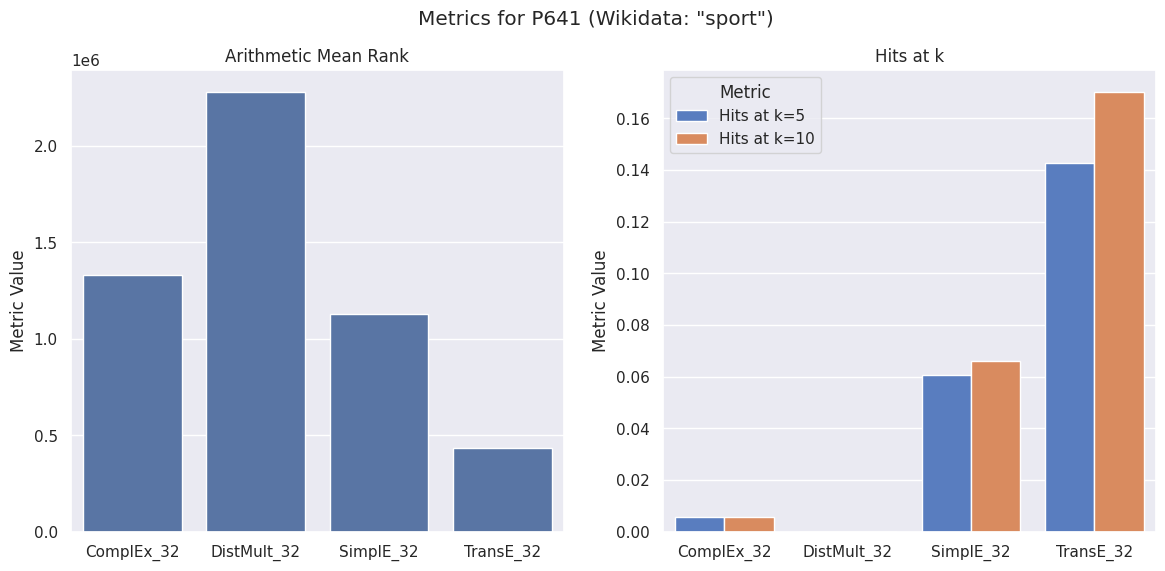

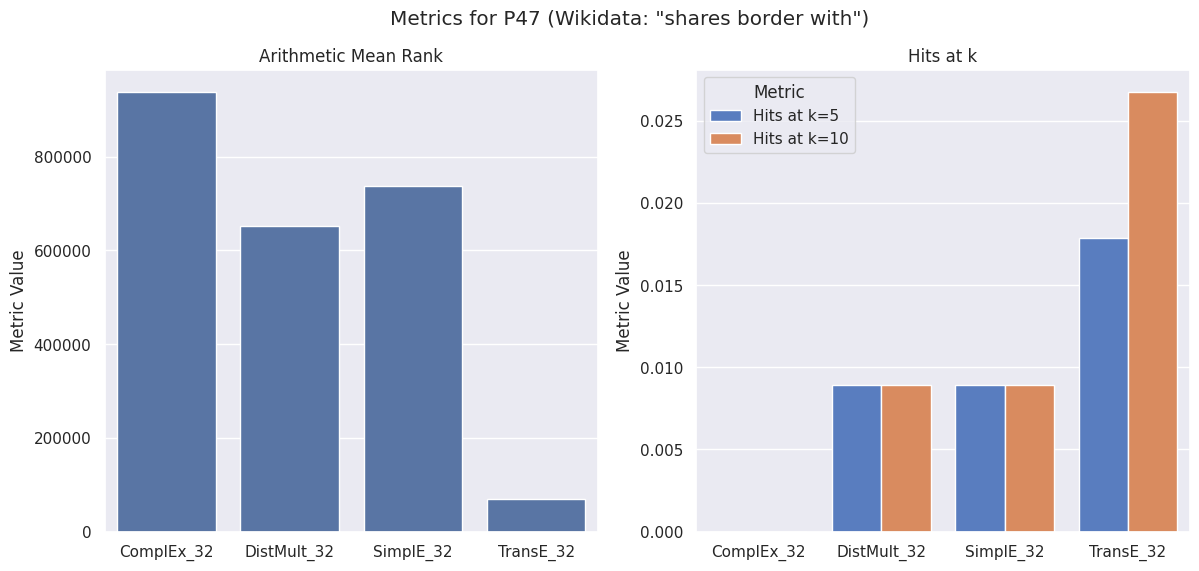

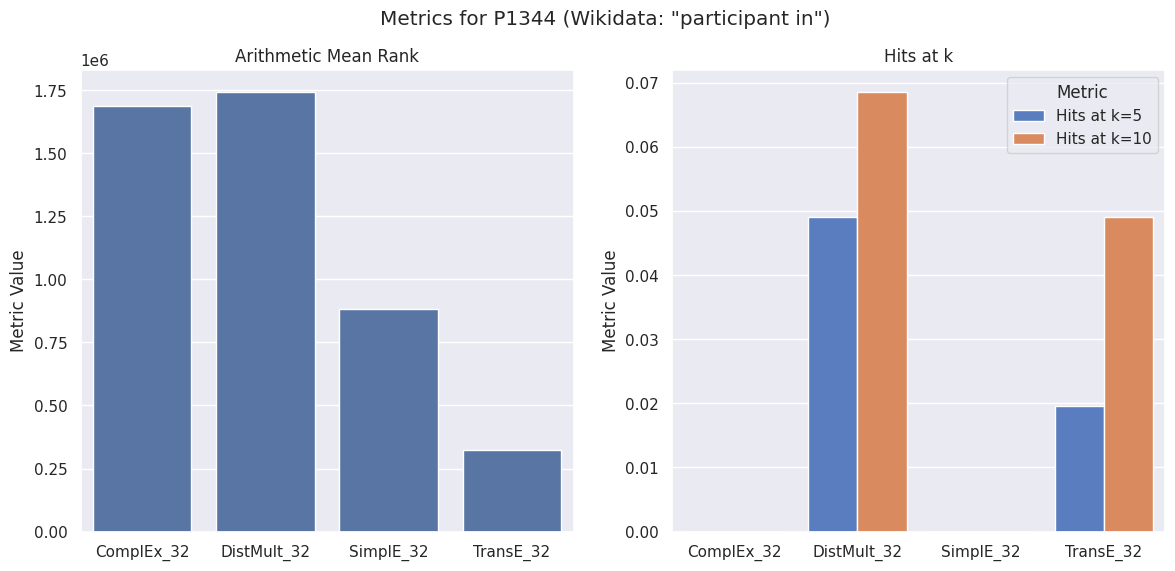

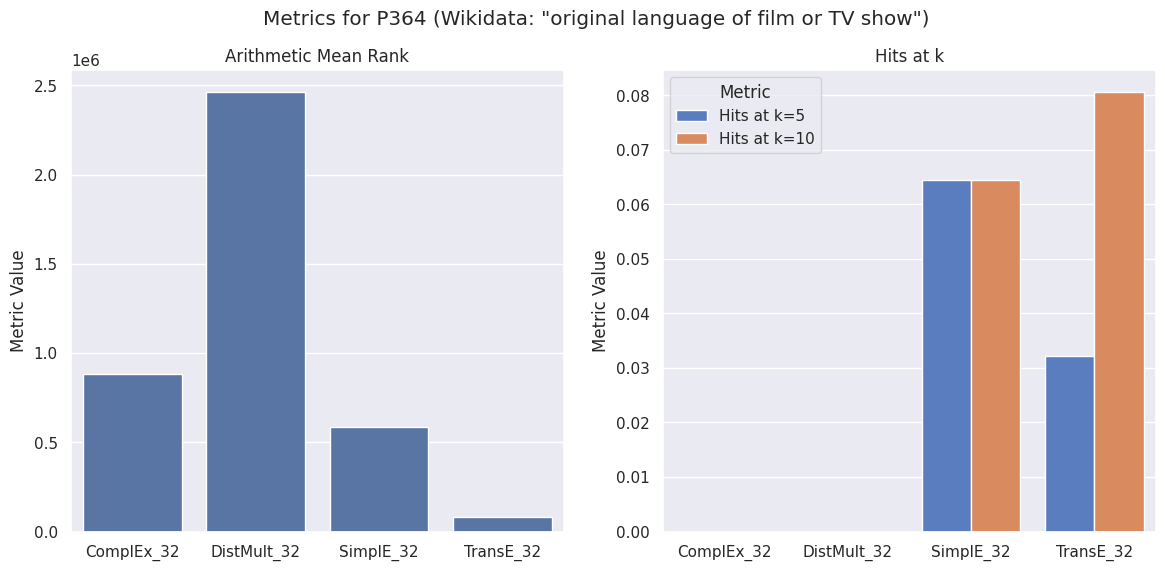

In [20]:
def plot_selected_predicate_metrics_grouped(predicate_metrics, predicate_list, embedding_dim=32, ylim_extend=1):
    sns.set_theme(style=SEABORN_THEME)

    wikidata_labels = get_wikidata_property_labels(predicate_list)

    for pred in predicate_list:
        pred_df = predicate_metrics[predicate_metrics['relation_label'] == pred]
        w_label = wikidata_labels[pred]

        # Sort by metric name to ensure correct ordering
        pred_df = pred_df.sort_values(by=['Metric', 'model'])

        # Filter values for each metric
        amr_values = pred_df[pred_df['Metric'] == 'arithmetic_mean_rank']
        hits5_values = pred_df[pred_df['Metric'] == 'hits_at_5']
        hits10_values = pred_df[pred_df['Metric'] == 'hits_at_10']

        # Invert arithmetic mean rank to have bigger values be better and
        # to comply with the hits at k axis (easier readability of the plot)
        # Hint: Add +1 to num_entities because PyKEEN ranks are 1-based
        inv_amr_values = (WIKIDATA5M_TRANSDUCTIVE_NUM_ENTITIES + 1) - amr_values['Value'].values

        # Create figure and axes
        fig, ax1 = plt.subplots(figsize=(10, 6))
        fig.suptitle(f'Metrics for {pred} (Wikidata: "{w_label}")')
        colors = ['blue', 'red', 'green']
        model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']

        if 'complex' not in pred_df['model'].unique():
            model_labels = ['DistMult', 'SimplE', 'TransE']

        model_labels = [f'{model}_{embedding_dim}' for model in model_labels]

        # Set bar width and positions
        bar_width = 0.2
        x_pos = np.arange(len(amr_values['model']))
        bar1_pos = x_pos - bar_width
        bar2_pos = x_pos
        bar3_pos = x_pos + bar_width

        # Plot Arithmetic Mean Rank on the left y-axis
        ax1.bar(bar1_pos, inv_amr_values, color=colors[0], width=bar_width, label='Arithmetic Mean Rank', zorder=3)
        ax1.set_ylabel('Inverted Arithmetic Mean Rank', color=colors[0])
        ax1.tick_params(axis='y', labelcolor=colors[0], zorder=0)
        ax1.grid(False)
        ax1.set_xticks(bar2_pos)
        ax1.set_xticklabels(model_labels)

        # Create a second y-axis for Hits at 5 and 10
        ax2 = ax1.twinx()
        ax2.bar(bar2_pos, hits5_values['Value'], color=colors[1], width=bar_width, label='Hits at k=5', zorder=3)
        ax2.bar(bar3_pos, hits10_values['Value'], color=colors[2], width=bar_width, label='Hits at k=10', zorder=3)
        ax2.set_ylabel('Hits at k', color='black')
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.grid(False)

        # Extend the y-axis to the top to create space for the legend,
        # without overlapping the bars
        ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * ylim_extend)
        ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1] * ylim_extend)

        # Combine legends for both axes
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

        # Show plot
        plt.show()
        

def plot_selected_predicate_metrics_subplots(predicate_metrics, predicate_list, embedding_dim=32):
    sns.set_theme(style=SEABORN_THEME)
    
    wikidata_labels = get_wikidata_property_labels(predicate_list)
    
    for pred in predicate_list:
        pred_df = predicate_metrics[predicate_metrics['relation_label'] == pred]
        w_label = wikidata_labels[pred]
        
        # Sort by metric name to ensure correct ordering
        pred_df = pred_df.sort_values(by=['Metric', 'model'])

        # Filter values for different metrics
        amr_values = pred_df[pred_df['Metric'] == 'arithmetic_mean_rank']
        hits_at_k_values = pred_df[pred_df['Metric'].isin(['hits_at_5', 'hits_at_10'])]
    
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
        fig.suptitle(f'Metrics for {pred} (Wikidata: "{w_label}")')
        model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']

        if 'complex' not in pred_df['model'].unique():
            model_labels = ['DistMult', 'SimplE', 'TransE']
            
        model_labels = [f'{model}_{embedding_dim}' for model in model_labels]
        hits_at_k_order = ['hits_at_5', 'hits_at_10']
        
        ax1 = sns.barplot(ax=axes[0], data=amr_values, x='model', y='Value')
        ax1.set_title('Arithmetic Mean Rank')
        ax1.set_xlabel('')
        ax1.set_ylabel('Metric Value')
        ax1.set_xticks(np.arange(len(model_labels)))
        ax1.set_xticklabels(model_labels)
        
        ax2 = sns.barplot(ax=axes[1], data=hits_at_k_values, x='model', y='Value', hue='Metric', hue_order=hits_at_k_order, palette='muted')
        ax2.set_title('Hits at k')
        ax2.set_xlabel('')
        ax2.set_ylabel('Metric Value')
        ax2.set_xticks(np.arange(len(model_labels)))
        ax2.set_xticklabels(model_labels)
        
        set_plot_legend_texts(ax2, 'Metric', ['Hits at k=5', 'Hits at k=10'])
        
        plt.show()


# plot_selected_predicate_metrics_grouped(dim32_predicate_metrics, example_predicates, embedding_dim=32, ylim_extend=1.05)
plot_selected_predicate_metrics_subplots(dim32_predicate_metrics, example_predicates, embedding_dim=32)

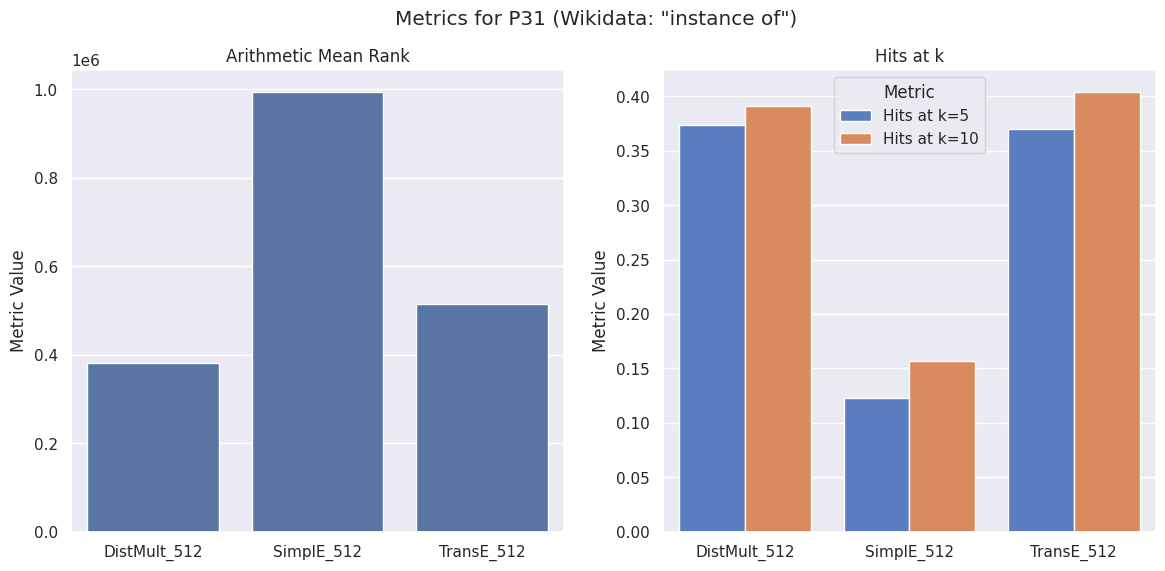

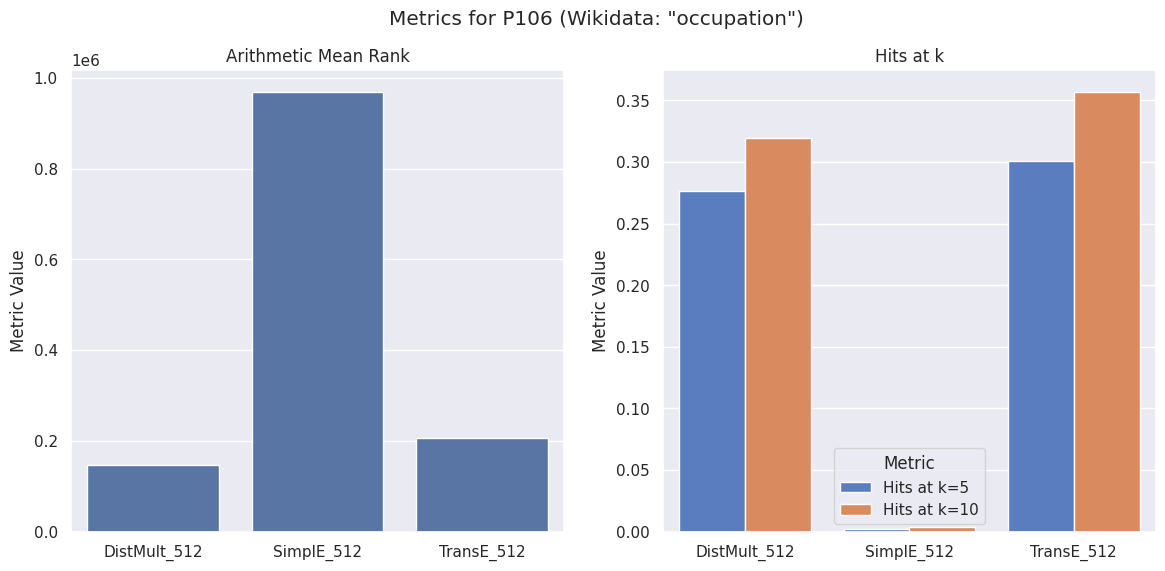

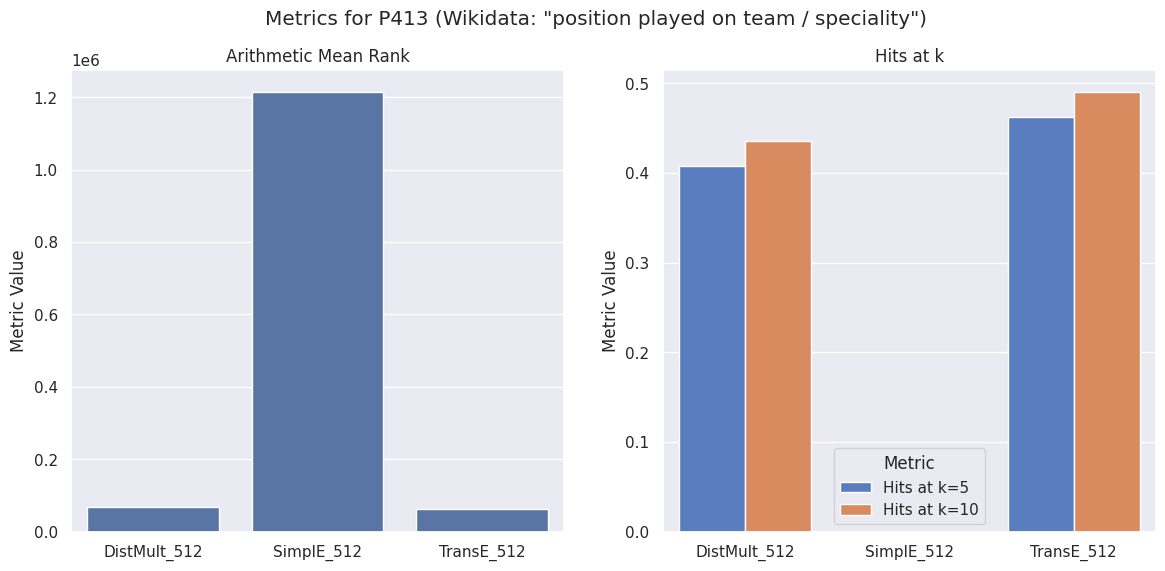

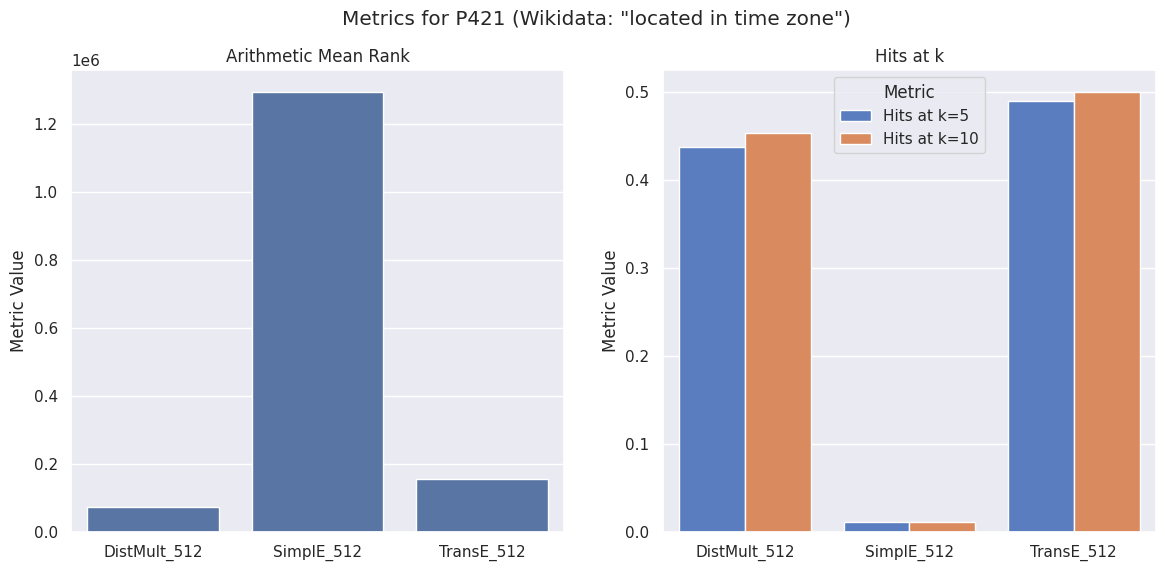

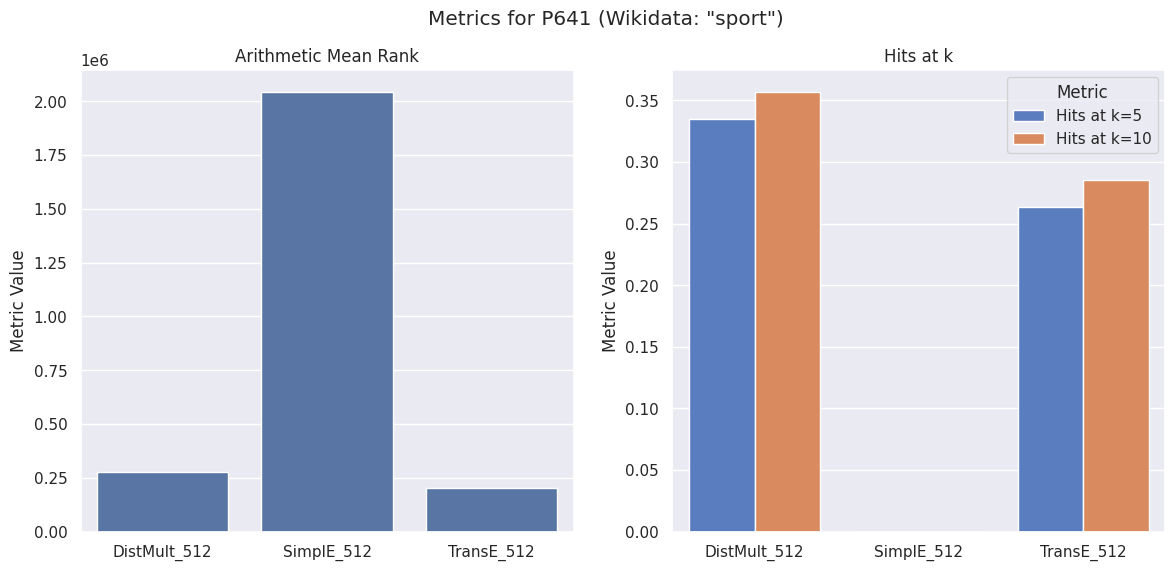

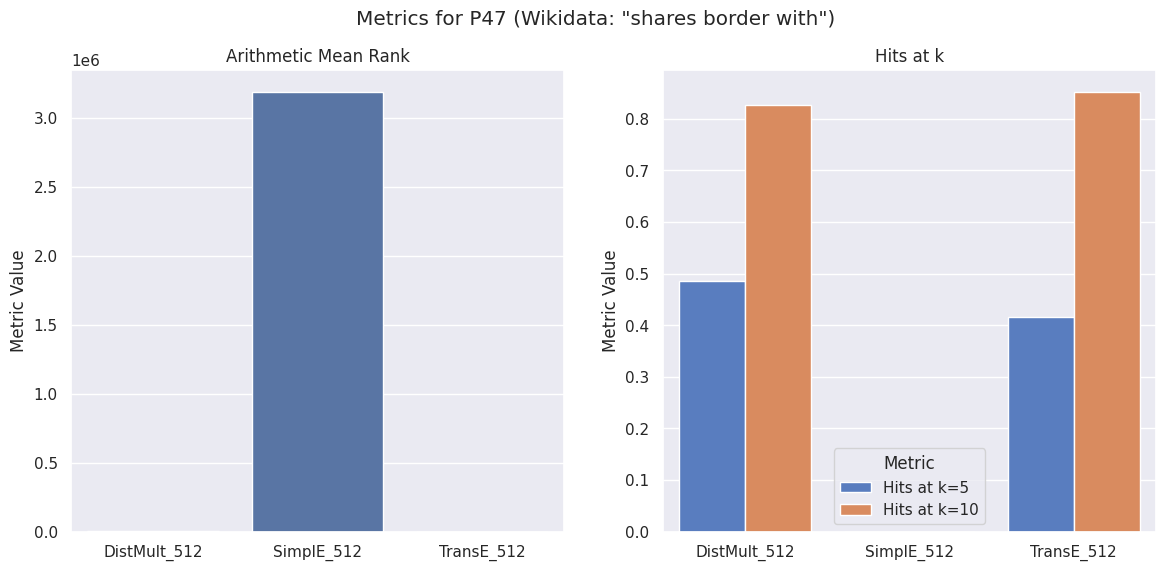

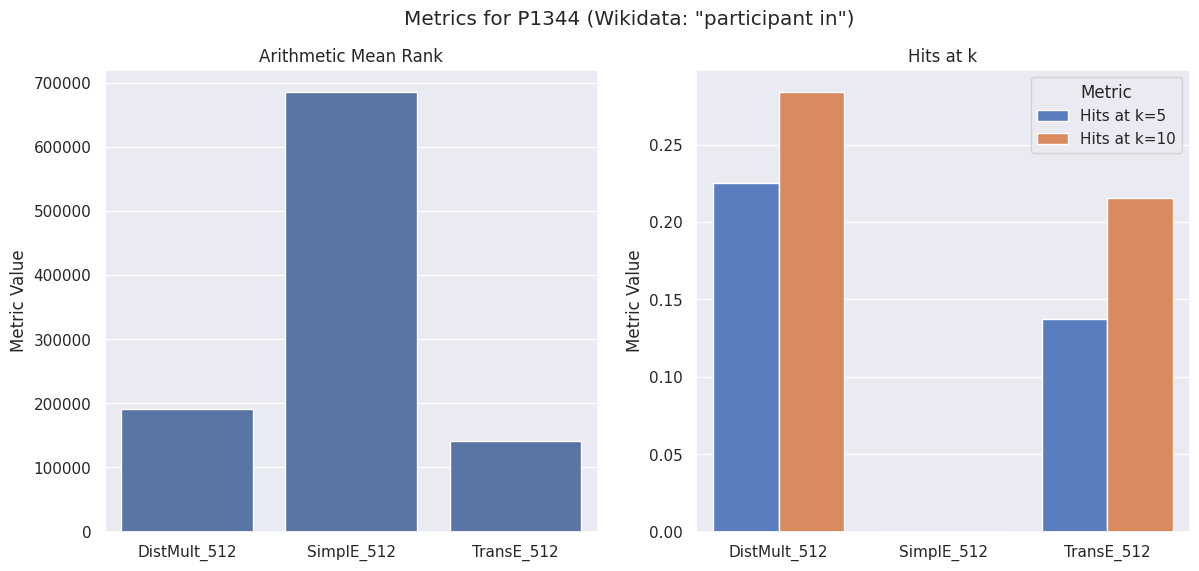

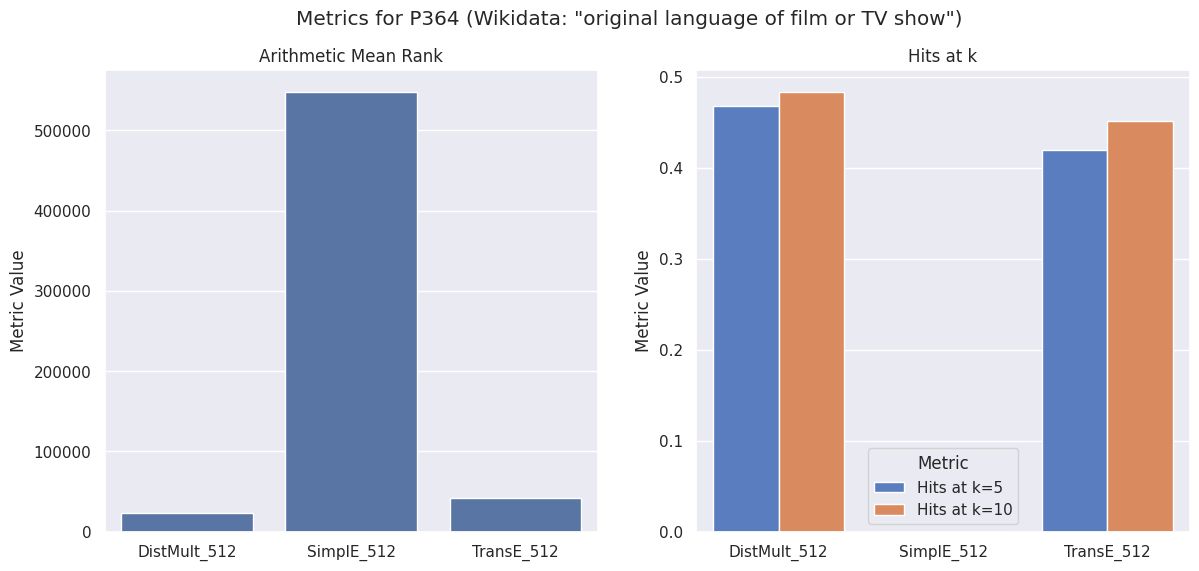

In [21]:
# plot_selected_predicate_metrics_grouped(dim512_predicate_metrics, example_predicates, embedding_dim=512, ylim_extend=1.17)
plot_selected_predicate_metrics_subplots(dim512_predicate_metrics, example_predicates, embedding_dim=512)

In [49]:
def compute_dataset_predicate_counts(predicates):
    triples_df = wikidata5m_train[wikidata5m_train['P'].isin(predicates)]
    
    wikidata_labels = get_wikidata_property_labels(predicates)

    predicate_counts = []
    individual_object_counts = []
    for pred, p_triples in triples_df.groupby(by='P'):
        pred_count = len(p_triples)
        w_label = wikidata_labels[pred]
        
        total_subject_count = len(p_triples['S'].unique())
        total_object_count = len(p_triples['O'].unique())
        
        predicate_counts.append([pred, w_label, pred_count, total_subject_count, total_object_count])
    
        object_counts_per_subject = p_triples.drop_duplicates(subset=['S', 'P', 'O']).value_counts(subset=['S', 'P'])
        object_counts_per_subject = object_counts_per_subject.rename('object_count').reset_index()
        
        individual_object_counts.append(object_counts_per_subject)

    predicate_counts_df = pd.DataFrame(predicate_counts, columns=['P', 'wd_label', 'pred_count', 'total_subject_count', 'total_object_count'])
    individual_object_counts_df = pd.concat(individual_object_counts)

    return predicate_counts_df, individual_object_counts_df


example_predicate_counts, example_predicate_object_counts = compute_dataset_predicate_counts(example_predicates)
example_predicate_counts

,P,wd_label,pred_count,total_subject_count,total_object_count
0,P106,occupation,1100875,809940,2791
1,P1344,participant in,222604,124179,7227
2,P31,instance of,3839805,3742149,18612
3,P364,original language of film or TV show,136520,131520,361
4,P413,position played on team / speciality,180987,177948,126
5,P421,located in time zone,404751,270094,103
6,P47,shares border with,429768,91822,92189
7,P641,sport,485665,481076,453


In [54]:
print(f'Number of object counts: {len(example_predicate_object_counts):,}')
example_predicate_object_counts.head(10)

Number of object counts: 5,828,728


,S,P,object_count
0,Q2227698,P106,16
1,Q270085,P106,15
2,Q22686,P106,14
3,Q296609,P106,14
4,Q1744,P106,13
5,Q762,P106,13
6,Q542101,P106,13
7,Q5879,P106,13
8,Q44414,P106,13
9,Q58720,P106,12


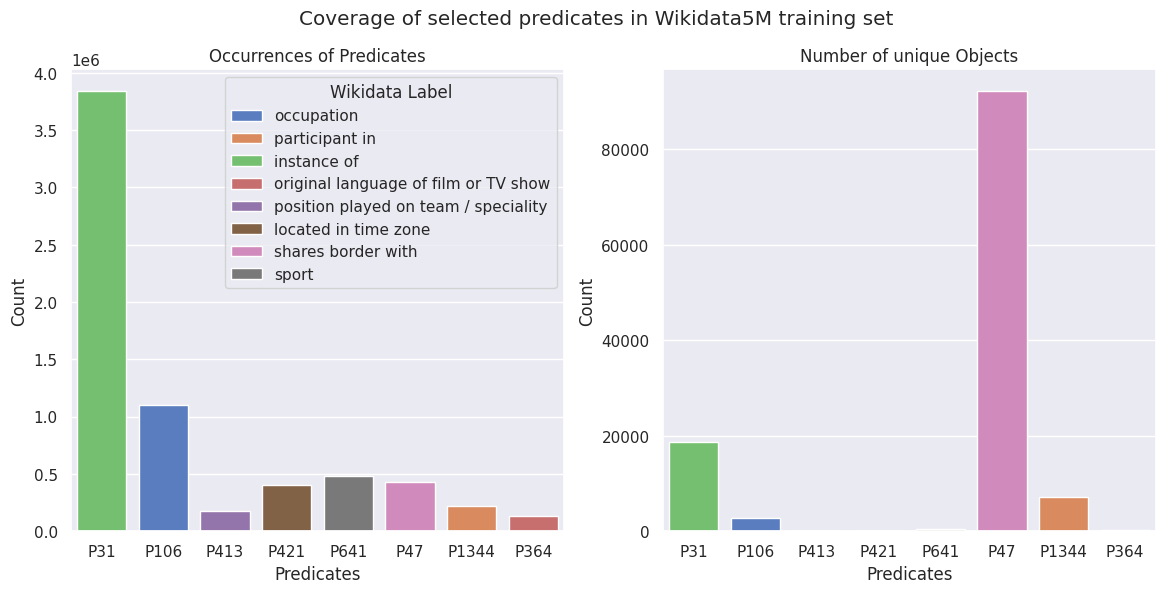

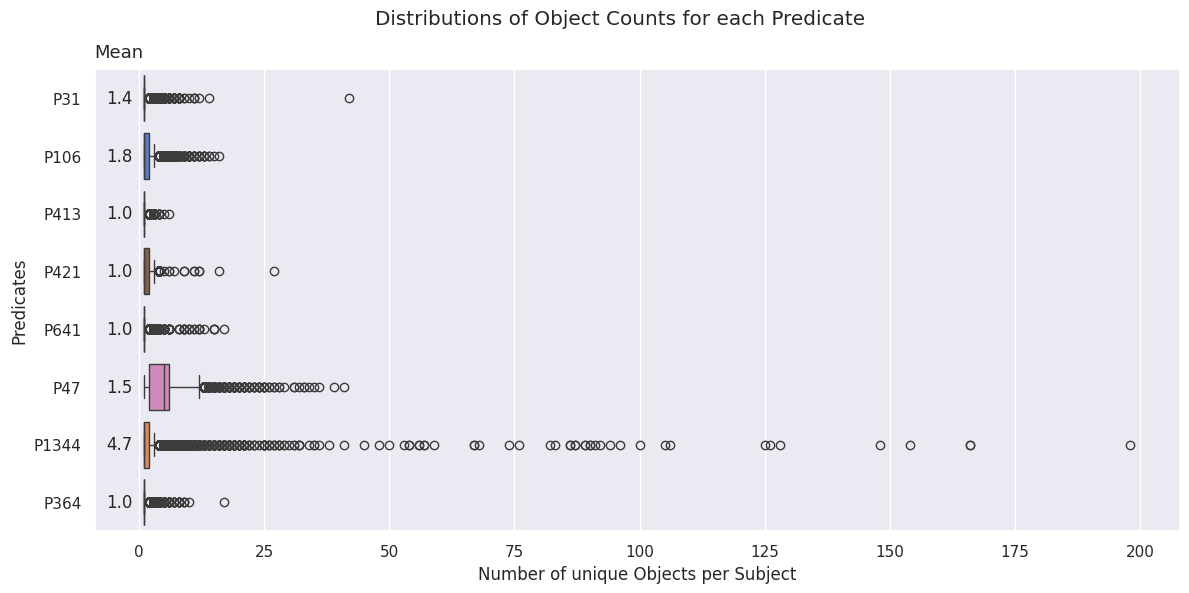

In [110]:
def plot_dataset_predicate_counts(predicate_counts, object_counts, sort_order):
    sns.set_theme(style=SEABORN_THEME)
    
    # Plotting two side-by-side bar plots with different y-axes
    fig1, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    fig1.suptitle('Coverage of selected predicates in Wikidata5M training set')
    
    # Plotting predicate counts
    ax1 = sns.barplot(x='P', y='pred_count', data=predicate_counts, ax=axes[0], hue='wd_label', order=sort_order, palette='muted')
    ax1.set_title('Occurrences of Predicates')
    ax1.set_xlabel('Predicates')
    ax1.set_ylabel('Count')
    ax1.legend(title='Wikidata Label')
    
    # Plotting object counts
    ax2 = sns.barplot(x='P', y='total_object_count', data=predicate_counts, ax=axes[1], hue='wd_label', order=sort_order, palette='muted', legend=False)
    ax2.set_title('Number of unique Objects')
    ax2.set_xlabel('Predicates')
    ax2.set_ylabel('Count')
    
    plt.show()
    
    for (_, pred, wd_label) in predicate_counts[['P', 'wd_label']].itertuples():
        object_counts.loc[object_counts['P'] == pred, 'wd_label'] = wd_label
        
    object_count_means = object_counts.groupby('P')['object_count'].mean()
    
    fig = plt.figure(figsize=(14, 6))
    fig.suptitle('Distributions of Object Counts for each Predicate')
    
    ax3 = sns.boxplot(y='P', x='object_count', data=object_counts, order=sort_order, orient='y', hue='wd_label', palette='muted', legend=False)
    ax3.set_xlabel('Number of unique Objects per Subject')
    ax3.set_ylabel('Predicates')
    
    predicate_yticks = ax3.get_yticks()
    ax3.text(-4, -0.8, 'Mean', ha='center', va='center', size=13)
    for ytick in predicate_yticks:
        ax3.text(-4, ytick, '%.1f' % object_count_means.iloc[ytick], ha='center', va='center', size='medium')
    
    plt.show()
    

plot_dataset_predicate_counts(example_predicate_counts, example_predicate_object_counts, example_predicates)

## Properties of selected predicates

### `P31` (instance of)

- that class of which this subject is a particular example and member
- relationship between instances with a common characteristic and a class characterized by this characteristic
- Use "instance of" instead of "subclass of" when there is no class hierarchy relationship
    - Example: "Atlantic Ocean" and "Pacific Ocean" are instances of "Ocean", but not subclasses
- not transitive
    - Example: "Angela Merkel" instance of "politician", "politician" instance of "profession", but "Angela Merkel" is not a "profession"
- not reflexive
- asymmetric

### `P106` (occupation)

- occupation of a person
- not transitive/reflexive/symmetric

### `P413` (position played on team / speciality)

- position or specialism of a player on a team
- not transitive/reflexive/symmetric

### `P421` (located in time zone)

- time zone for this item
- not transitive/reflexive/symmetric

### `P641` (sport)

- sport that the subject participates or participated in or is associated with
- not transitive/reflexive/symmetric

### `P47` (shares border with)

- countries or administrative subdivisions, of equal level, that this item borders, either by land or water. A single common point is enough.
- symmetric property
    - Example: "South Africa" shares border with "Botswana", "Botswana" shares border with "South Africa"
- not transitive/reflexive

### `P1344` (participant in)

- event in which a person or organization was/is a participant
- not transitive/reflexive/symmetric

### `P364` (original language of film or TV show)

- language in which a film or a performance work was originally created
- Deprecated for written works and songs; use P407 ("language of work or name") instead.
- not transitive/reflexive/symmetric